In [1]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA

import joblib

%matplotlib inline
import warnings

In [2]:
df = pd.read_csv('../data/nba_logreg.csv')
print('Nombre de joueurs dans la base de données : ' + str(len(df)))

Nombre de joueurs dans la base de données : 1340


La base de données est assez petite.

In [3]:
df.isnull().sum() # cherche les variables avec des valeurs manquantes

Name            0
GP              0
MIN             0
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%             0
OREB            0
DREB            0
REB             0
AST             0
STL             0
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

In [4]:
y = df['TARGET_5Yrs']
X = df.drop('Name',  axis=1)
X = X.drop('TARGET_5Yrs', axis=1)

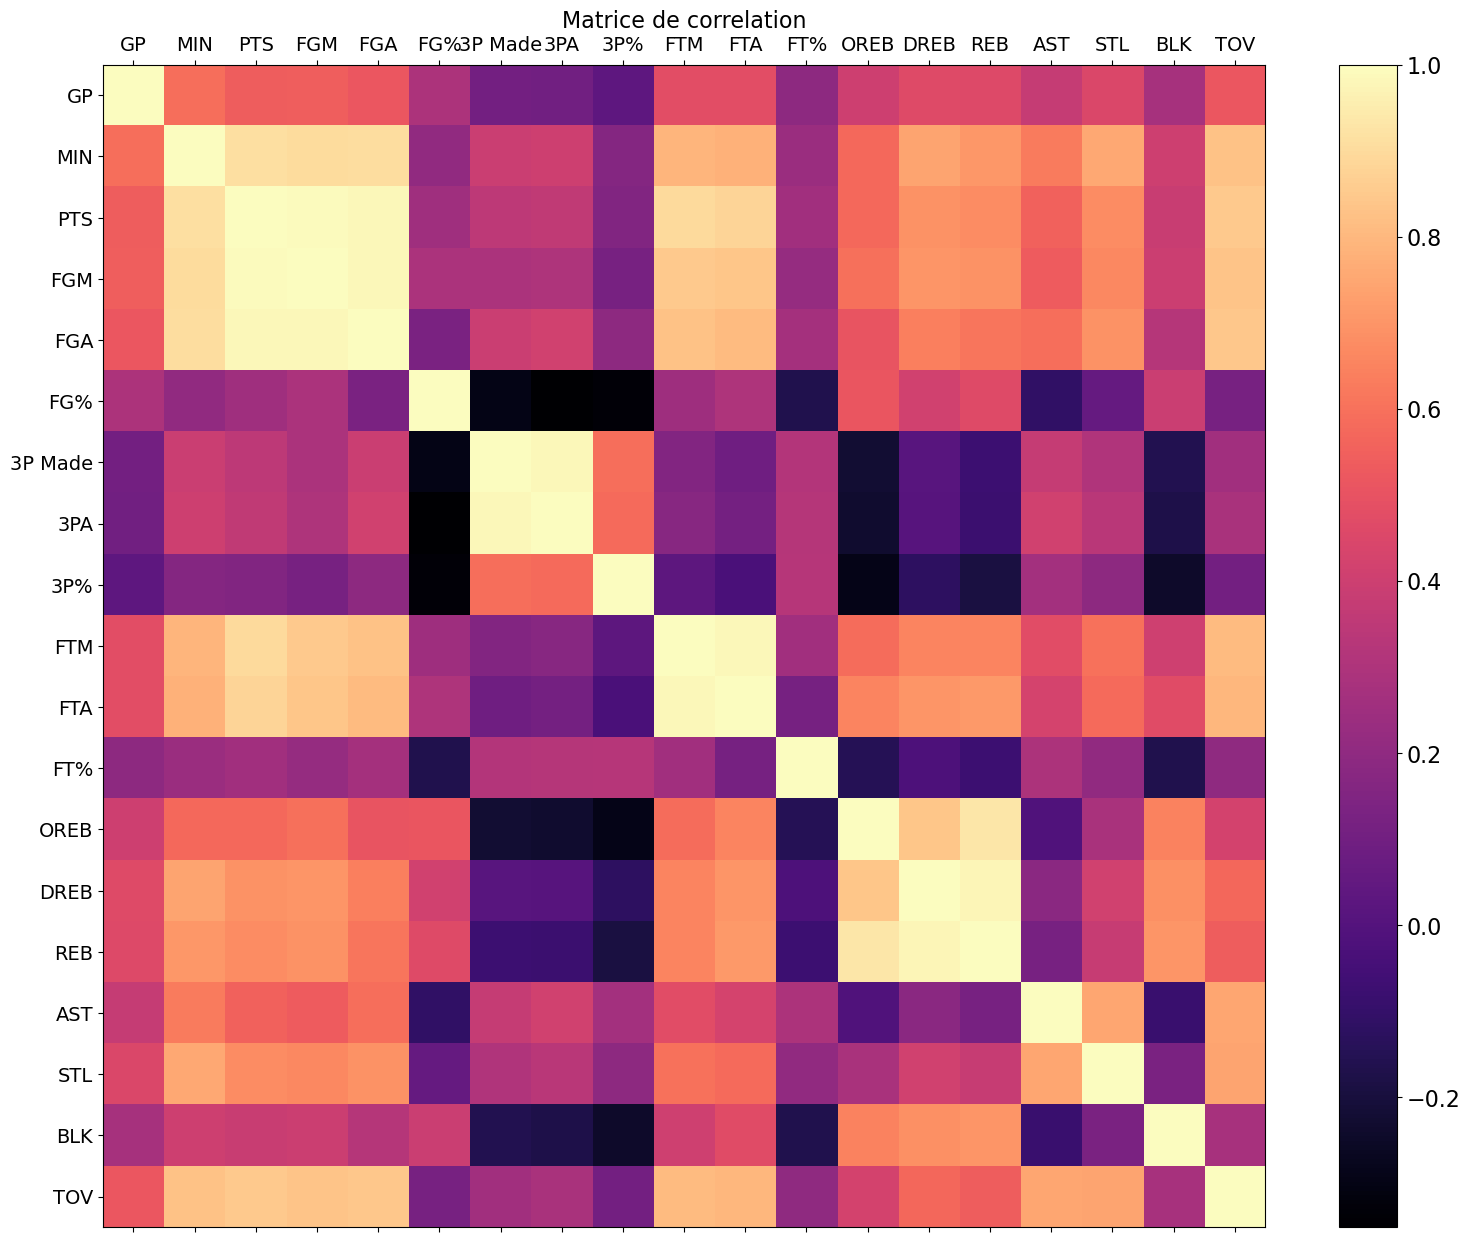

In [5]:
corr = X.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(X.corr(), fignum=f.number,  cmap=cm.get_cmap('magma'))
plt.xticks(range(len(corr.columns)), corr.columns, fontsize=14);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=14);

cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title('Matrice de correlation', fontsize=16);

La stratégie que nous allons poursuivre ici est d'enlever des variables très correlées afin d'éviter la multicolinéarité (on considère qu'au delà de 0.5 les variables sont très correlées).

Une autre alternative serait aussi d'orthogonaliser les données à l'aide de l'analyse en composantes principales
et de ne retenir que les coposantes qui expliquent une part significative de la variance.


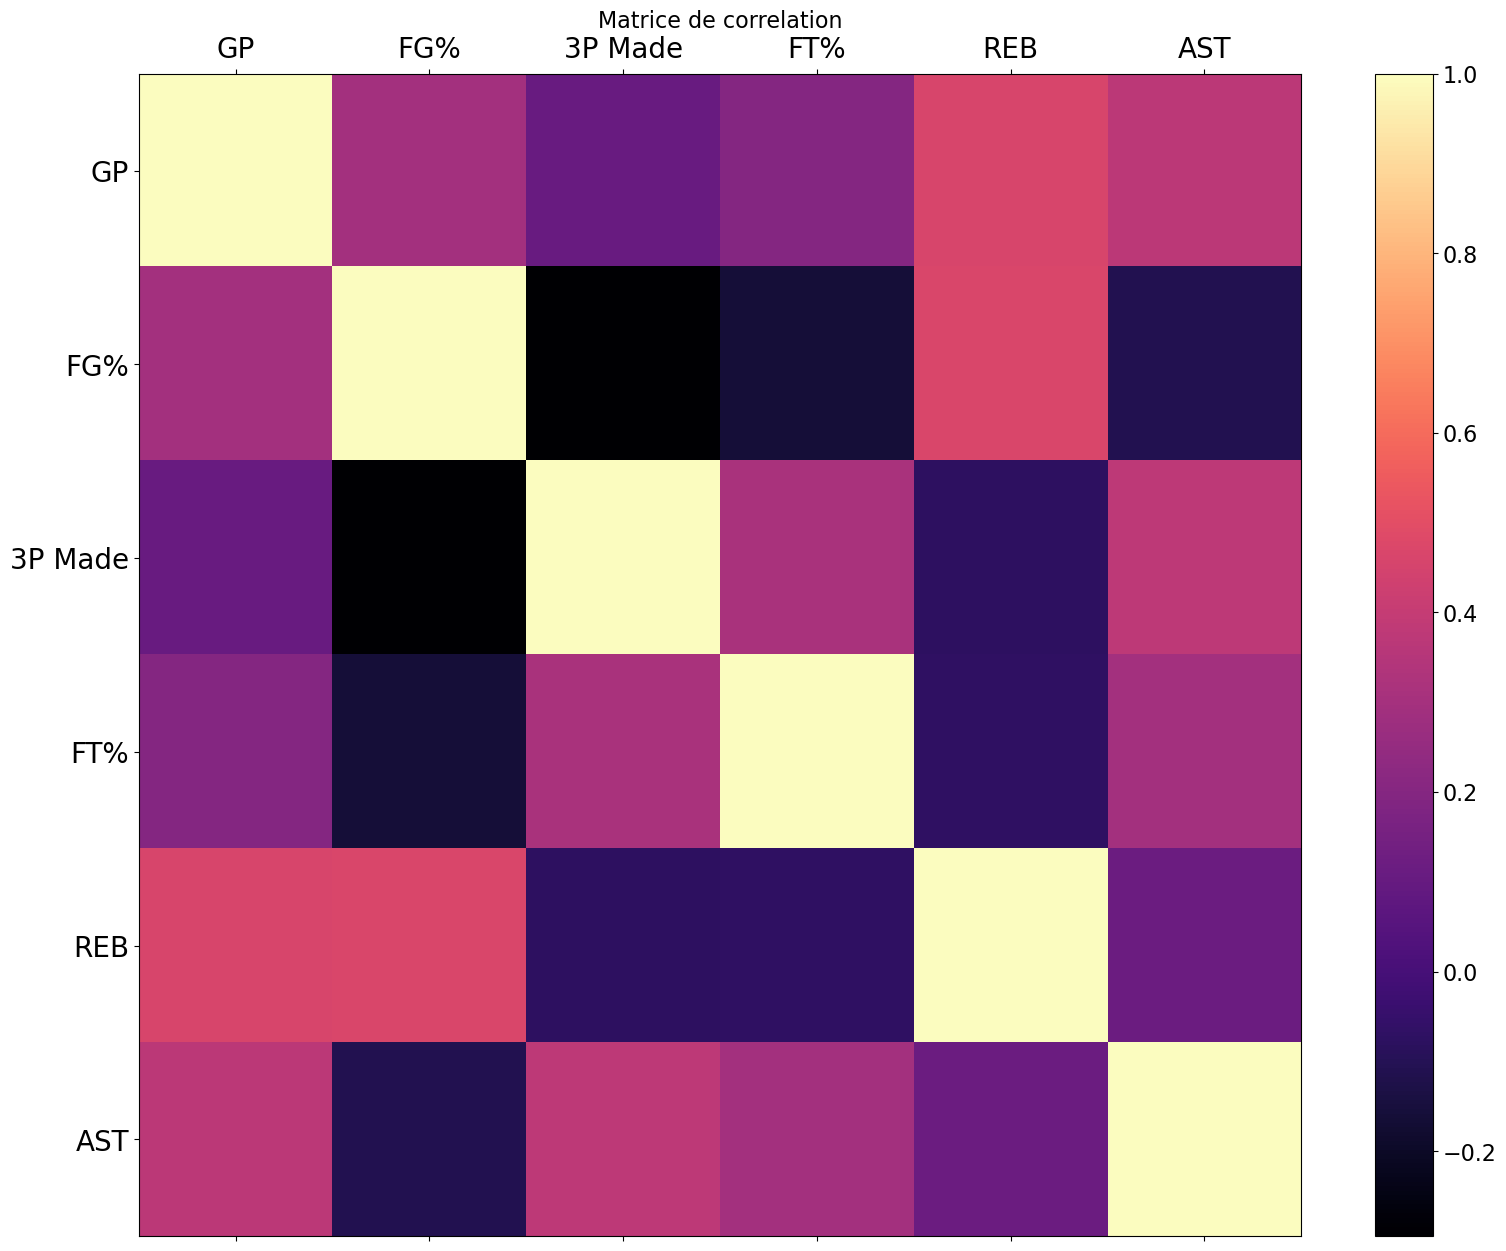

In [6]:
 # variables à garder:
cols = ['GP','FG%','3P Made','FT%','REB','AST']

corr = X[cols].corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(X[cols].corr(), fignum=f.number,  cmap=cm.get_cmap('magma'))
plt.xticks(range(len(corr.columns)), corr.columns, fontsize=20);
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=20);
cb = plt.colorbar()
cb.ax.tick_params(labelsize=16)
plt.title('Matrice de correlation', fontsize=16);

# Explorer si les classes sont bien équilibrées

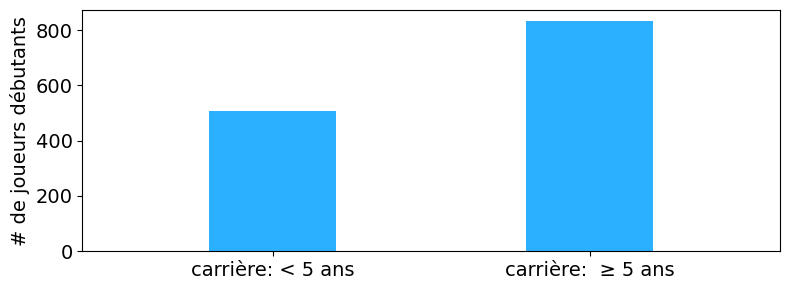

In [7]:
labels, counts = np.unique(y.to_numpy(), return_counts=True)
plt.figure(figsize=(8,3)) 
plt.bar(labels, counts, align='center', facecolor = '#2ab0ff', width=0.4)
plt.gca().set_xticks(labels)
plt.gca().set_xticklabels(['carrière: < 5 ans','carrière:  ≥ 5 ans'], fontsize=14)
plt.gca().set_ylabel('# de joueurs débutants', fontsize=14)
plt.xlim(-0.6, 1.6)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Les classes ne sont pas totalement équilibrées, mais assez pour faire une crossvalidation simple (non stratifiée).

Ceci nous donne aussi la performance de base (l'accuracy  ou  le taux de précision correcte), le rappel, la précision et le F1-score d un modèle naïf qui prédirait la classe majoritaire: 
    
Valeurs approchées:    
    
Acc  (Dummy)  = (TP + TN) / Total Population ≈ 800 / (800 + 500) ≈ 61%

Prec (Dummy)  =  TP / (TP + FP) ≈   800 / (800 + 500) ≈ 61%

Rec  (Dummy)  =  TP / (TP + FN) ≈   800/800 ≈ 1

F1   (Dummy)  =  2.Prec.Rec / (Prec + Rec) ≈ 76,19 %

In [8]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X, y)
y_pred = dummy_clf.predict(X)
print('Valeurs exactes: ')
print('Recall: ' + str(recall_score(y, y_pred)))
print('Precision: ' + str(precision_score(y, y_pred)))
print('F1-score: ' + str(f1_score(y, y_pred)))

Valeurs exactes: 
Recall: 1.0
Precision: 0.6201492537313433
F1-score: 0.7655458314140949


# Observer la distribution des données pour savoir comment les normaliser

In [9]:
def plot_hist(X, variable_short_name, variable_large_name, ax = None):
    "observe variables distribution"
    
    x = X[variable_short_name].values
    ax.hist(x, bins=70, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
    ax.set_ylabel('Number of players', fontsize=15) 
    ax.set_xlabel(variable_large_name, fontsize=15)
    ax.set_title(variable_short_name, fontsize=22)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    
    return ax

/tmp/ipykernel_16767/2012719681.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_16767/2012719681.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)


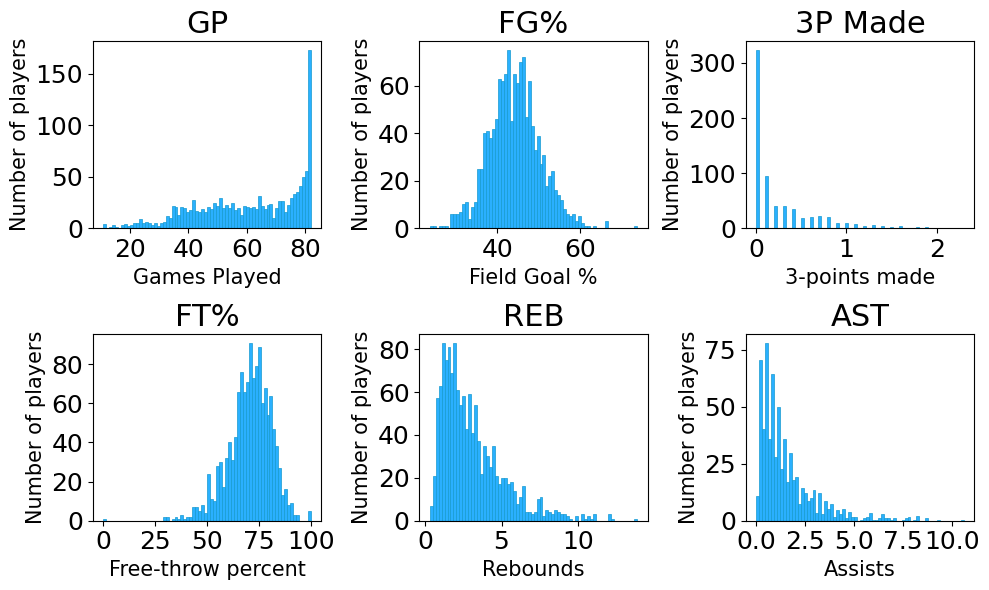

In [10]:
fig, ax = plt.subplots(2,3, figsize=(10, 6))
plot_hist(X, 'GP', 'Games Played', ax[0,0]);
plot_hist(X, 'FG%', 'Field Goal %', ax[0,1]);
plot_hist(X, '3P Made', '3-points made', ax[0,2]);
plot_hist(X, 'FT%', 'Free-throw percent', ax[1,0]);
plot_hist(X, 'REB', 'Rebounds', ax[1,1]);
plot_hist(X, 'AST', 'Assists', ax[1,2]);
fig.tight_layout()

Le premier constat est que les variables ont des échelles différentes. On peut donc les normaliser 
ou les mettre à l'échelle (même si certains classificateurs comme les arbres de décisions ou d'autres ne sont pas 
sensibles aux changements d'échelle').

Le deuxième constat est que les variables n'ont pas la même distribution. Nous allons  les normaliser 
avec une transformation qui les rendra plus gaussiennes et qui sera robuste aux valeurs abérantes- par exemple dans le cas de la variable FT% - on utilisera la transformation PowerTransformer/method='yeo-johnson'. En ce qui concerne la variable 3P made, nous allons juste la centrer.

In [11]:
X_norm = X[cols].copy()

In [12]:
power1          = PowerTransformer(method='yeo-johnson', standardize=True)
X_norm[['GP']]  = power1.fit_transform(X_norm[['GP']].values.reshape(-1, 1))

In [13]:
power2          = PowerTransformer(method='yeo-johnson', standardize=True)
X_norm[['FG%']] = power2.fit_transform(X_norm[['FG%']].values.reshape(-1, 1))

In [14]:
power3          = PowerTransformer(method='yeo-johnson', standardize=True)
X_norm[['FT%']] = power3.fit_transform(X_norm[['FT%']].values.reshape(-1, 1))

In [15]:
power4          = PowerTransformer(method='yeo-johnson', standardize=True)
X_norm[['REB']] = power4.fit_transform(X_norm[['REB']].values.reshape(-1, 1))

In [16]:
power5          = PowerTransformer(method='yeo-johnson', standardize=True)
X_norm[['AST']] = power5.fit_transform(X_norm[['AST']].values.reshape(-1, 1))

In [17]:
std_sc              = StandardScaler()
X_norm[['3P Made']] = std_sc.fit_transform(X_norm[['3P Made']].values.reshape(-1, 1))

/tmp/ipykernel_16767/2012719681.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_16767/2012719681.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)


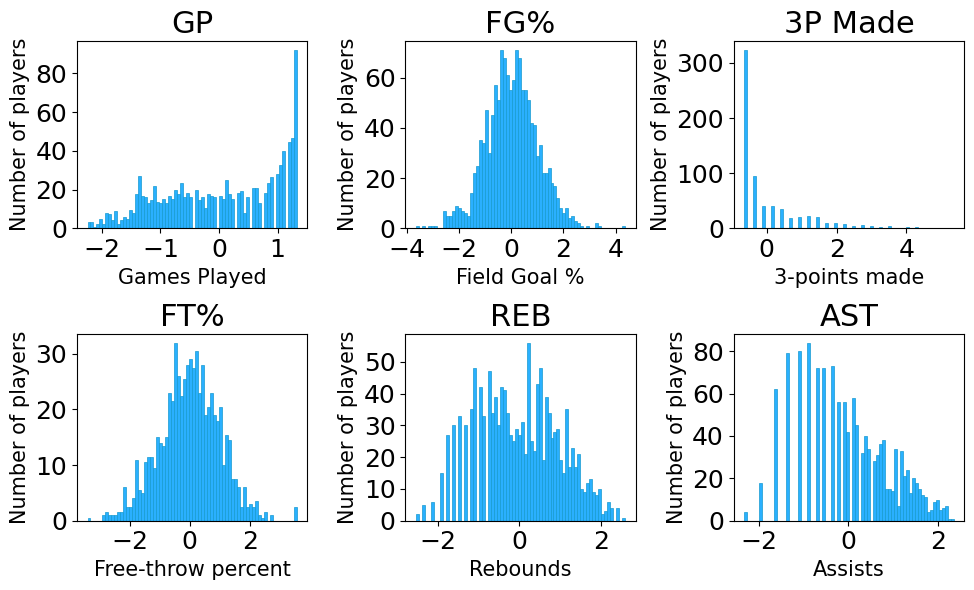

In [18]:
fig, ax = plt.subplots(2,3, figsize=(10, 6))
plot_hist(X_norm, 'GP', 'Games Played', ax[0,0]);
plot_hist(X_norm, 'FG%', 'Field Goal %', ax[0,1]);
plot_hist(X_norm, '3P Made', '3-points made', ax[0,2]);
plot_hist(X_norm, 'FT%', 'Free-throw percent', ax[1,0]);
plot_hist(X_norm, 'REB', 'Rebounds', ax[1,1]);
plot_hist(X_norm, 'AST', 'Assists', ax[1,2]);
fig.tight_layout()

# Model optimisation

Je choisis d'utiliser le score F1, la moyenne harmonique entre le rappel et la précision, car choisir seulement le rappel -le 'recall'- peut privilégier naïvement des modèles peu précis (61%). Comme on l'a vu précédemment, le rappel du modèle naïf est de 1.

In [19]:
def nested_cv(data, target, model_to_tune, param_grid, n_trials=1):
    """
    Nested cross validation: crossvalidation in order to reduce overfitting
    trough several estimates on a validation set and reduces bias for model 
    evaluation on test set.
    data:    dataframe, or numpy
    target:  label (in here 1s or 0's)
    model_to_tune: untuned model (ie model_to_tune = SVC())
    param_grid: dict {'parameter_name': float or list of floats}
    n_trials: repetitions to ensure that result do not depend on the sampling.
    """

    test_score_nested = []
    for i in range(n_trials):
        inner_cv = KFold(n_splits=5, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)
        model = GridSearchCV(estimator=model_to_tune, param_grid=param_grid,
                             cv=inner_cv, n_jobs=4, scoring = 'f1')
        model.fit(data, target)
        test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2, scoring = 'f1')
        test_score_nested.append(test_score.mean())

    return test_score_nested, model

 ### a) Modèle de base: régression logistique

In [21]:
param_grid = {'penalty': ['elasticnet'],
              'C':[0.001, 0.05, 0.08],                   # 0.01, 0.05, 0.1 , 1, 10
              'class_weight': ['balanced',None],
              'l1_ratio': [ 0.7, 0.9, 1],          # 0, 0.1, 0.3, 0.5,
              'max_iter': [5, 7, 10, 20],
              'solver':['saga']
             }
model_to_tune = LogisticRegression(verbose=0)

In [ ]:
test_score_nested_lr, model_lr = nested_cv(X_norm, y, model_to_tune, param_grid, n_trials=5);

In [22]:
print('scores : ')
print(test_score_nested_lr)

scores : 
[0.7761932318438348, 0.7759708290789612, 0.7781531877350489, 0.7680120374337823, 0.7724641206597055]


In [23]:
model_lr.best_estimator_

LogisticRegression(C=0.05, l1_ratio=0.7, max_iter=7, penalty='elasticnet',
                   solver='saga')

### b) SVM

In [24]:
param_grid = {"C": [ 0.1, 1, 10, 100],       # 0.01, 100
               'kernel':['linear', 'rbf']},  #"gamma": 'scale', [0.001, 0.01, 0.1, 1]
                                             # ,'poly','sigmoid'
                                             # 'degree': [3, 5, 10]
model_to_tune = SVC()

In [52]:
test_score_nested_svm, model_svm = nested_cv(X_norm, y, model_to_tune, param_grid, n_trials=5)

In [53]:
print('scores : ')
print(test_score_nested_svm)

scores : 
[0.7463409351542287, 0.7302846990809173, 0.7279176754710966, 0.7462950316114685, 0.7372649315851966]


### c) Random Forest classifier

In [41]:
param_grid ={'bootstrap': [True, False],
             'max_depth': [53],                 # 20, 100
             'max_features': ['auto', 'sqrt'], 
             'min_samples_leaf': [  15, 23],    # 30, 50, 100 
             'min_samples_split': [ 50],        # 10, 100, 40
             'n_estimators': [20]}              # 30, 40, 100 
model_to_tune = RandomForestClassifier()

In [43]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
with warnings.catch_warnings():
    simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

test_score_nested_rf, model_rf = nested_cv(X_norm, y, model_to_tune, param_grid, n_trials=5);

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/ds_test/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behavio

In [44]:
model_rf.best_estimator_

RandomForestClassifier(max_depth=53, min_samples_leaf=15, min_samples_split=50,
                       n_estimators=20)

Lorsque Je regarde les paramètres du meilleur estimateur pour savoir si je suis dans un 'bord' des jeux de paramètres et si c'est le cas, je rajoutte des valeurs à gauche (si le paramètre est le plus petit) ou respectivement à droite, et je recommence le fit.

In [54]:
print('scores : ')
print(test_score_nested_rf)

scores : 
[0.7683228817804387, 0.7607903622890091, 0.7621871145240872, 0.7613936667310736, 0.7683939344420531]


### d) Hist Gradient Boosting Classifier

In [47]:
param_grid = {'loss':['log_loss'],
              'learning_rate':[0.1],
              'max_iter': [50],       # , 100, 200
              'max_leaf_nodes': [ 30, 100], # None, 5,
              'max_depth':[ 10, 40],    # None, 3,
              #'min_samples_leaf': [5, 20, 100],
              #'l2_regularization':[0, 0.01, 0.1, 1, 10],
              'max_bins':[255],
             }
model_to_tune = HistGradientBoostingClassifier()

In [48]:
test_score_nested_hgb, model_hgb = nested_cv(X_norm, y, model_to_tune, param_grid, n_trials=5)

In [49]:
print('scores : ')
print(test_score_nested_hgb)

scores : 
[0.7463409351542287, 0.7302846990809173, 0.7279176754710966, 0.7462950316114685, 0.7372649315851966]


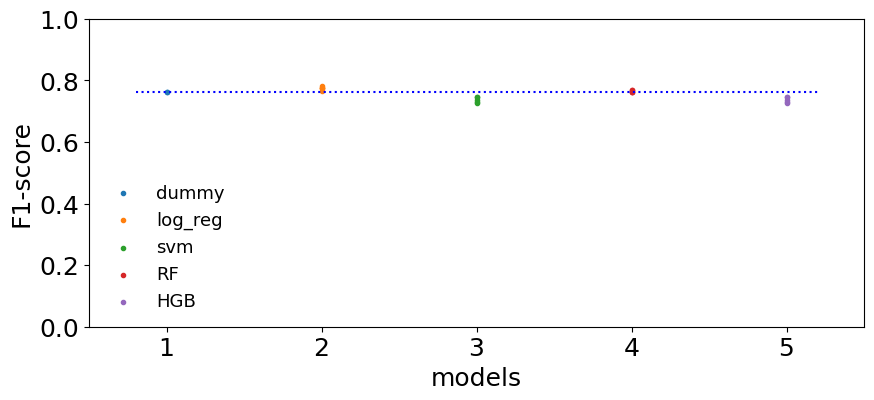

In [55]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(np.linspace(0.8, 5.2, 10), 0.7619*np.ones(10), ':b')
ax.scatter([1,1],[0.7619, 0.7619], label= 'dummy', marker = '.')
ax.scatter(2*np.ones(5),test_score_nested_lr, label= 'log_reg', marker = '.')
ax.scatter(3*np.ones(5),test_score_nested_svm, label= 'svm', marker = '.')
ax.scatter(4*np.ones(5),test_score_nested_rf, label= 'RF', marker = '.')
ax.scatter(5*np.ones(5),test_score_nested_hgb, label= 'HGB', marker = '.')
ax.set_xlim(0.5, 5.5)
ax.set_ylim(0, 1)
ax.set_ylabel("F1-score",fontsize=18)
ax.set_xlabel("models", fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18);
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18);
ax.legend(frameon=False, fontsize=13);

Je n'arrive pas à voir de différence entre les modèles (et surtout non plus de différence par rapport au modèle naïf) malgré de nombreuses tentatives pour trouver une plage de valeurs qui améliorerait les performances des modèles. 

Ceci peut être dû:

a- Un choix de variables qui n'est pas approprié.

b- L'abcense de structure dans les données, de lien "causal" ou "corrélatif" (au sens large) avec la variable prédite. 

In [56]:
def plot_hists_var_outcome(X, y, variable_short_name, variable_large_name, ax=None, Normalize=True):
    """
    observe if there is a difference in the distributions of the variables that 
    have a positive outcome from 
    """
    
    if Normalize == True:
        ylabel = 'Proportion of players'
    else:
        ylabel = 'Number of players'

    one_class  = X.loc[y.values == 1][variable_short_name].values
    zero_class = X.loc[y.values == 0][variable_short_name].values
    
    ax.hist(one_class, bins=70, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5, label = '≥ 5y',  alpha = 0.5, density=Normalize)
    ax.hist(zero_class, bins=70, facecolor = '#00DFA2', edgecolor='#00DFA2', linewidth=0.5, label = '< 5y', alpha = 0.5, density=Normalize)
    ax.set_ylabel(ylabel, fontsize=15)
    ax.set_xlabel(variable_large_name, fontsize=15)
    ax.set_title(variable_short_name, fontsize=22)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
    ax.legend()
    
    return ax

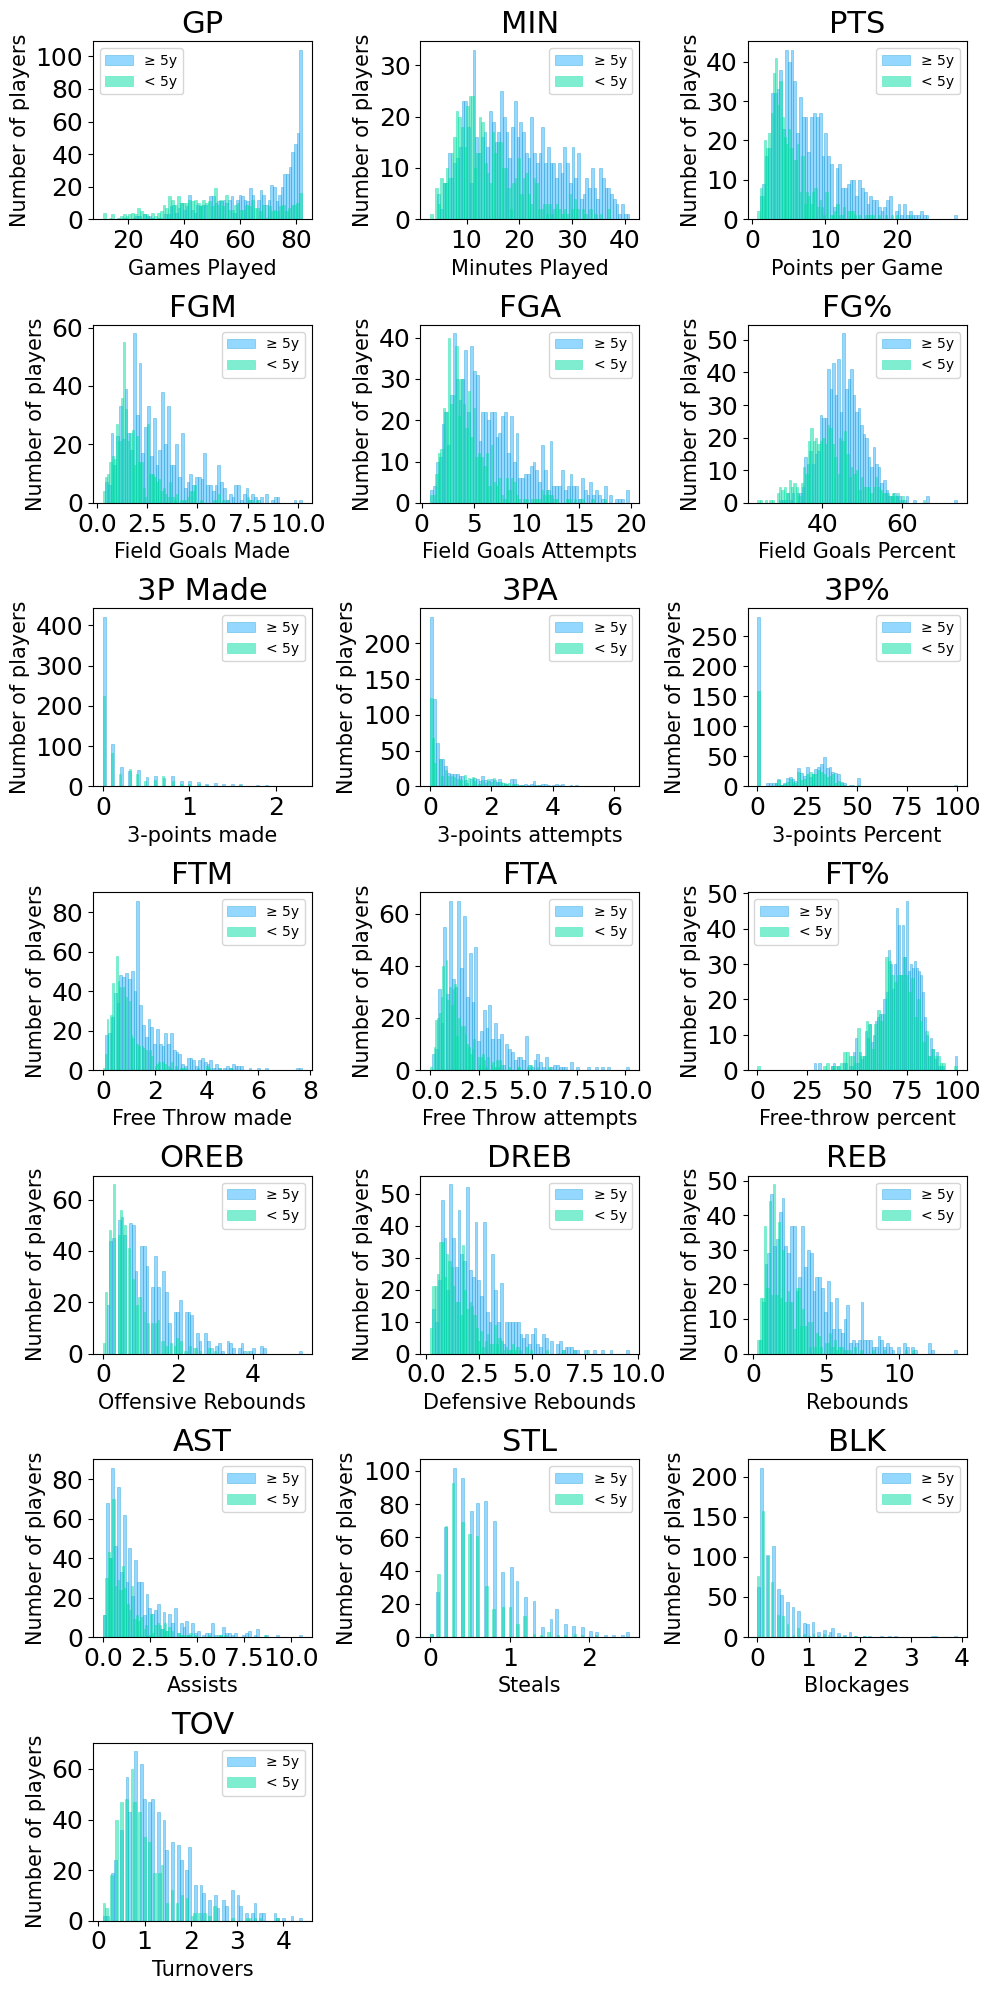

In [57]:
fig, ax = plt.subplots(7,3, figsize=(10, 20))
plot_hists_var_outcome(X, y, 'GP', 'Games Played', ax[0,0], Normalize=False);
plot_hists_var_outcome(X, y, 'MIN', 'Minutes Played', ax[0,1], Normalize=False);
plot_hists_var_outcome(X, y, 'PTS', 'Points per Game', ax[0,2], Normalize=False);
plot_hists_var_outcome(X, y, 'FGM', 'Field Goals Made', ax[1,0], Normalize=False);
plot_hists_var_outcome(X, y, 'FGA', 'Field Goals Attempts', ax[1,1], Normalize=False);
plot_hists_var_outcome(X, y, 'FG%', 'Field Goals Percent', ax[1,2], Normalize=False);
plot_hists_var_outcome(X, y, '3P Made', '3-points made', ax[2,0], Normalize=False);
plot_hists_var_outcome(X, y, '3PA', '3-points attempts', ax[2,1], Normalize=False);
plot_hists_var_outcome(X, y, '3P%', '3-points Percent', ax[2,2], Normalize=False);
plot_hists_var_outcome(X, y, 'FTM', 'Free Throw made', ax[3,0], Normalize=False);
plot_hists_var_outcome(X, y, 'FTA', 'Free Throw attempts', ax[3,1], Normalize=False);
plot_hists_var_outcome(X, y, 'FT%', 'Free-throw percent', ax[3,2], Normalize=False);
plot_hists_var_outcome(X, y, 'OREB', 'Offensive Rebounds', ax[4,0], Normalize=False);
plot_hists_var_outcome(X, y, 'DREB', 'Defensive Rebounds', ax[4,1], Normalize=False);
plot_hists_var_outcome(X, y, 'REB', 'Rebounds', ax[4,2], Normalize=False);
plot_hists_var_outcome(X, y, 'AST', 'Assists', ax[5,0], Normalize=False);
plot_hists_var_outcome(X, y, 'STL', 'Steals', ax[5,1], Normalize=False);
plot_hists_var_outcome(X, y, 'BLK', 'Blockages', ax[5,2], Normalize=False);
plot_hists_var_outcome(X, y, 'TOV', 'Turnovers', ax[6,0], Normalize=False);
ax[6,1].axis('off')
ax[6,2].axis('off')

fig.tight_layout()

A première vue, l'hypothèse selon laquelle il n'y a pas de structure dans les données semble devoir être écartée.
Car lorsque l'on voit MIN ,PTS ou FGA, il semble y avoir des différences dans les deux distributions, les variables 
conditionelles MIN|y= 1 semblent avoir une moyenne légérement supérieure aux variables conditionnelles MIN|y=0.

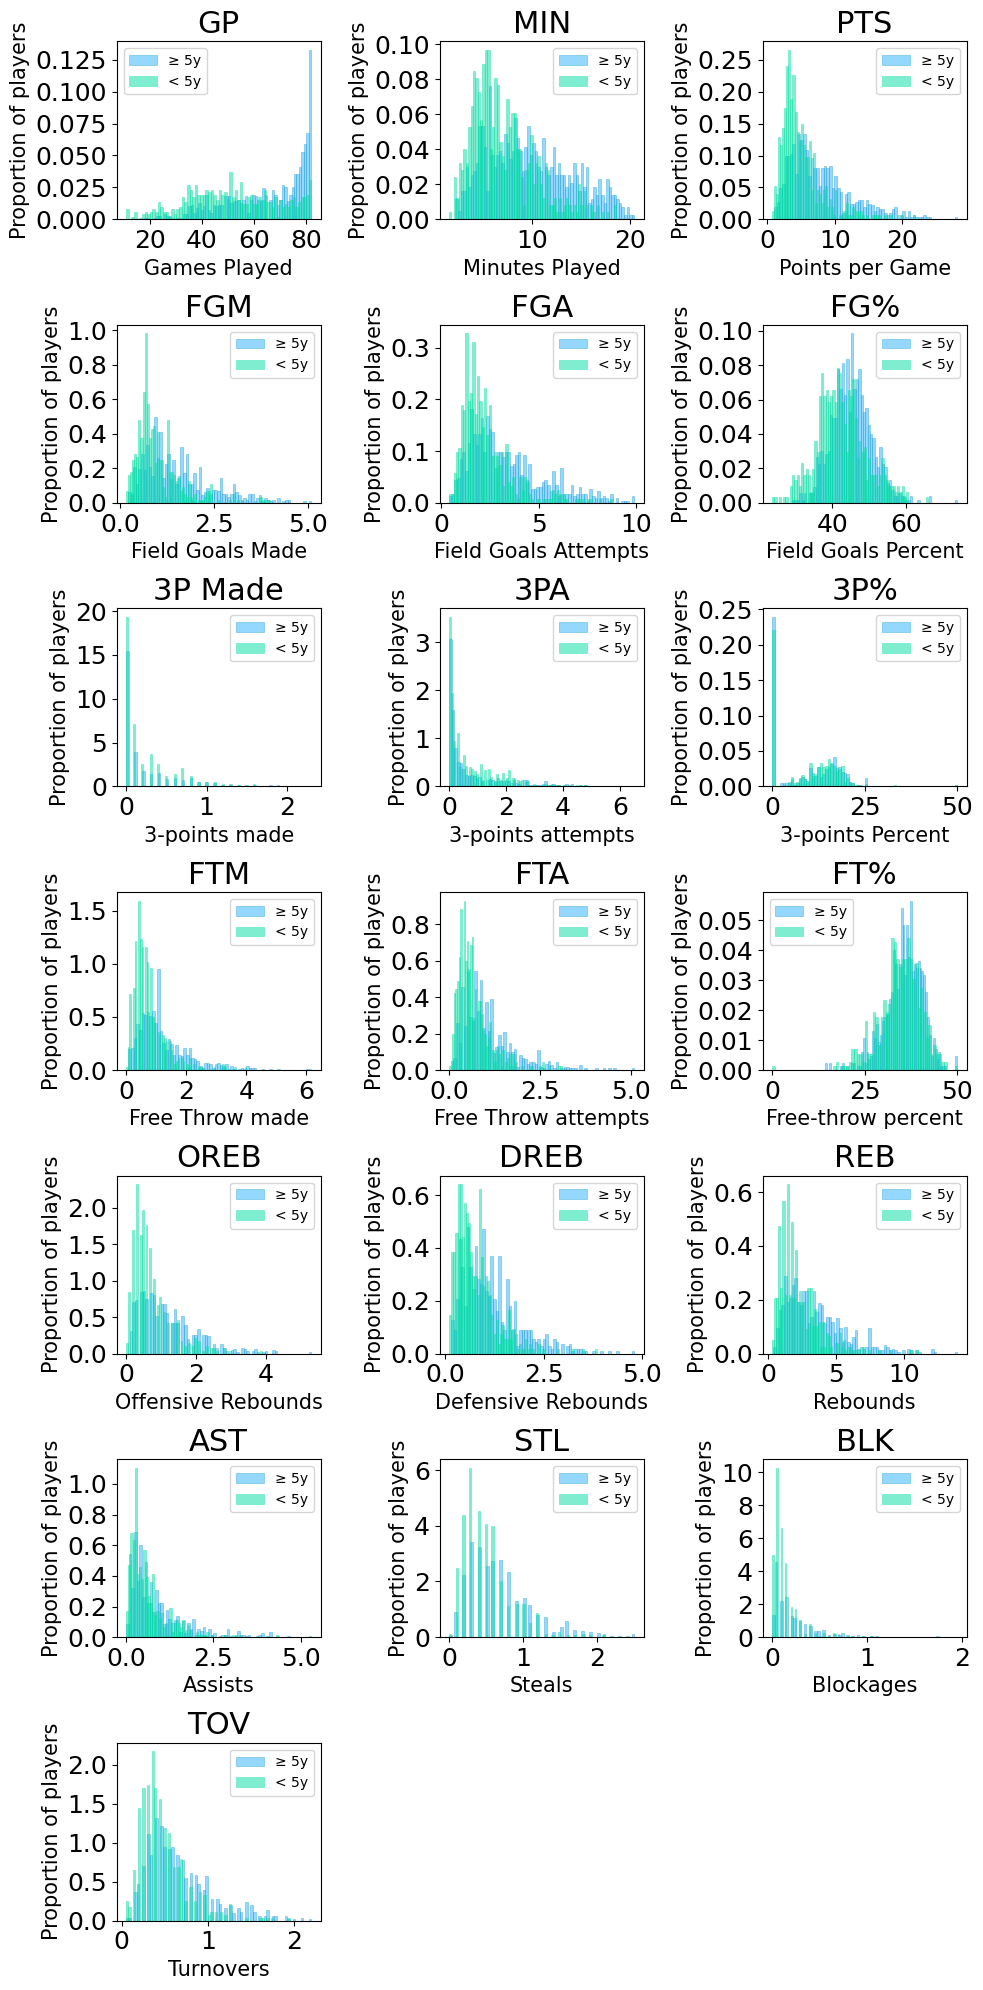

In [58]:
fig, ax = plt.subplots(7,3, figsize=(10, 20))
plot_hists_var_outcome(X, y, 'GP', 'Games Played', ax[0,0]);
plot_hists_var_outcome(X, y, 'MIN', 'Minutes Played', ax[0,1]);
plot_hists_var_outcome(X, y, 'PTS', 'Points per Game', ax[0,2]);
plot_hists_var_outcome(X, y, 'FGM', 'Field Goals Made', ax[1,0]);
plot_hists_var_outcome(X, y, 'FGA', 'Field Goals Attempts', ax[1,1]);
plot_hists_var_outcome(X, y, 'FG%', 'Field Goals Percent', ax[1,2]);
plot_hists_var_outcome(X, y, '3P Made', '3-points made', ax[2,0]);
plot_hists_var_outcome(X, y, '3PA', '3-points attempts', ax[2,1]);
plot_hists_var_outcome(X, y, '3P%', '3-points Percent', ax[2,2]);
plot_hists_var_outcome(X, y, 'FTM', 'Free Throw made', ax[3,0]);
plot_hists_var_outcome(X, y, 'FTA', 'Free Throw attempts', ax[3,1]);
plot_hists_var_outcome(X, y, 'FT%', 'Free-throw percent', ax[3,2]);
plot_hists_var_outcome(X, y, 'OREB', 'Offensive Rebounds', ax[4,0]);
plot_hists_var_outcome(X, y, 'DREB', 'Defensive Rebounds', ax[4,1]);
plot_hists_var_outcome(X, y, 'REB', 'Rebounds', ax[4,2]);
plot_hists_var_outcome(X, y, 'AST', 'Assists', ax[5,0]);
plot_hists_var_outcome(X, y, 'STL', 'Steals', ax[5,1]);
plot_hists_var_outcome(X, y, 'BLK', 'Blockages', ax[5,2]);
plot_hists_var_outcome(X, y, 'TOV', 'Turnovers', ax[6,0]);
ax[6,1].axis('off')
ax[6,2].axis('off')
fig.tight_layout()

  Néanmoins, après normalisation, les distributions semblent se superposer (peut être à l'exception seulement GP, et MIN, qui sont elles mêmes assez correlées). Il n'est pas à exclure que ces différences résiduelles observées soient un effet de la taille de l'échantillon. Une hypothèse serait alors que les modèles n'apprenent que ce qu'ils peuvent apprendre de mieux, c'est à dire le modèle naïf, parce que les données d'entrée ne sont pas prédictives de la variable à prédire. Avant de conclure définitivement essayons d'entrainer une régréssion linéaire et un SVM et un arbre de décions avec seulement la variable GP.

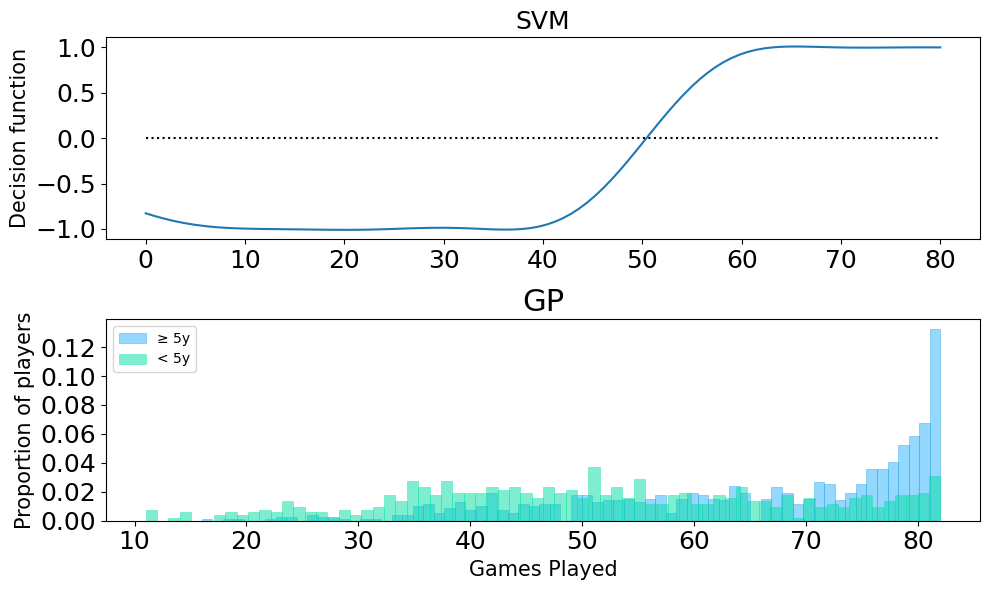

In [59]:
clf = SVC(random_state=0)
clf.fit(X[['GP']], y.values.reshape(-1,1))

fig, ax = plt.subplots(2,1,figsize=(10, 6))
ax[0].plot(np.linspace(0,80,100).reshape(-1,1), clf.decision_function(np.linspace(0,80,100).reshape(-1,1)))
ax[0].set_ylabel('Decision function', fontsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=18)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=18)
ax[0].plot(np.linspace(0,80,100), np.zeros(100),':k')
ax[0].set_title('SVM', fontsize=18)

plot_hists_var_outcome(X, y, 'GP', 'Games Played', ax[1]);
fig.tight_layout()

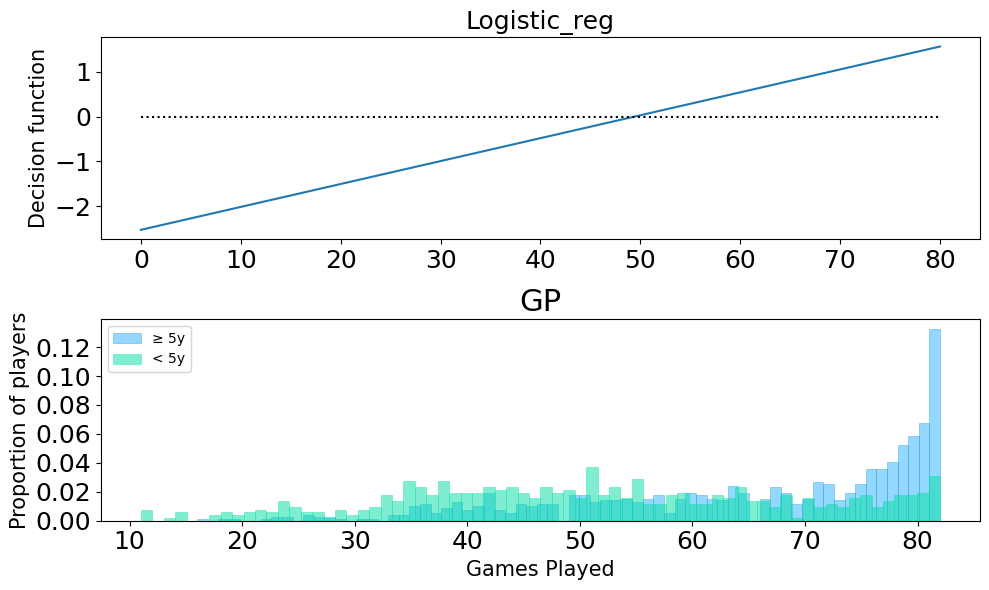

In [60]:
clf = LogisticRegression()
clf.fit(X[['GP']], y.values.reshape(-1,1))

fig, ax = plt.subplots(2,1,figsize=(10, 6))
ax[0].plot(np.linspace(0,80,100).reshape(-1,1), clf.decision_function(np.linspace(0,80,100).reshape(-1,1)))
ax[0].set_ylabel('Decision function', fontsize=15)
ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize=18)
ax[0].set_yticklabels(ax[0].get_yticklabels(), fontsize=18)
ax[0].plot(np.linspace(0,80,100), np.zeros(100),':k')
ax[0].set_title('Logistic_reg', fontsize=18)

plot_hists_var_outcome(X, y, 'GP', 'Games Played', ax[1]);
fig.tight_layout()

Finalement, je suis bien convaincu que le modèle apprend bien quelque chose, et que ce n'est pas le modèle naïf
Il reste cependant que les scores entre les modèles plus avancés et entre le modèle naïf soient égaux (ce qui est par ailleurs une étrange coïncidence).

Par ailleurs, il est attendu que les performances actuelles d'un joueur reflètent son niveau et son effort passé, et aient également une certaine valeur prédictive. Mais il est à noter que la variable prédite (durée de la carrière supérieure ou pas à 5 ans), est difficilement parfaitement prévisible: d'abord parce que cinq années,  c'est beaucoup de temps, et puis ensuite il faudrait aussi prendre en compte d'autres critères non présents dans la base de données par exemple l’alimentation, le niveau de préparation physique, l’historique des lésions…

## Modèle final choisi: regréssion logistique

Au vu de la taille du jeu de données, et des donnés en présence, il n'est pas absurde qu'un modèle très biaisé 
ait des performances similaires aux performances des autres modèles beaucoup plus complexes.

Text(0, 0.5, 'Weights')

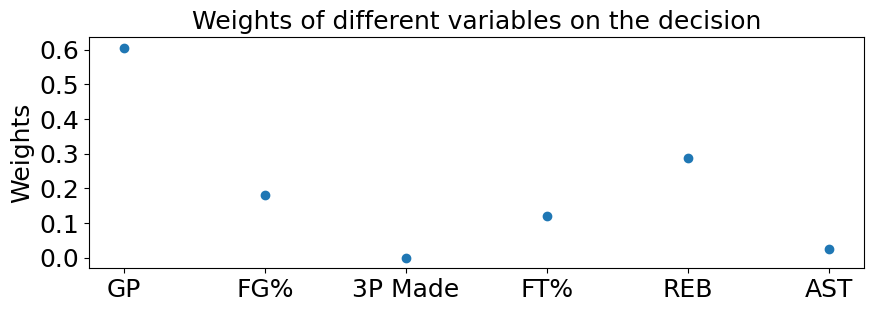

In [61]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(np.linspace(0,5,6), model_lr.best_estimator_.coef_)
ax.set_xticks((0, 1, 2, 3, 4, 5))
ax.set_xticklabels(tuple(cols), fontsize=18)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_title('Weights of different variables on the decision', fontsize=18)
ax.set_ylabel('Weights', fontsize=18)


Les poids ont un poids "positif" dans la décision, dans la mesure où se sont tous des indicateurs positivement correlés avec la performance sportive.

## Dernière analyse: dimensionalité des données

Je fais une analyse en composantes principales pour avoir une idée de la dimensionalité des données

In [62]:
X   = X.fillna(0)
n   = len(X.columns)
pca = PCA(n_components=n)
pca.fit(X)

PCA(n_components=19)

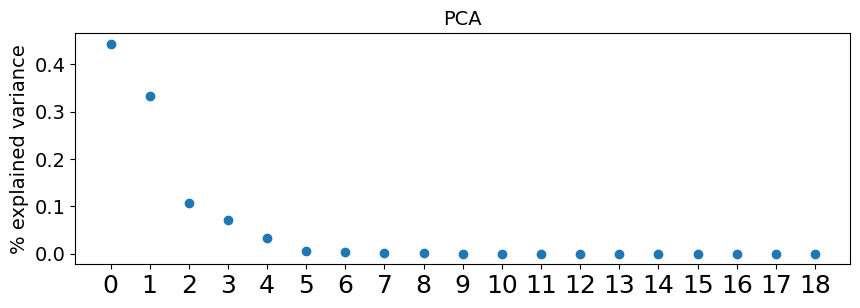

In [63]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.scatter(np.arange(n), pca.explained_variance_ratio_)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(np.arange(n), fontsize=18)

ax.set_yticklabels(ax.get_yticklabels(), fontsize=14);
ax.set_ylabel('% explained variance', fontsize=14);
ax.set_title('PCA', fontsize=14);

Visiblement, les données ont deux dimensions, ce qui montre qu'il était judicieux de diminuer le nombre de variables.

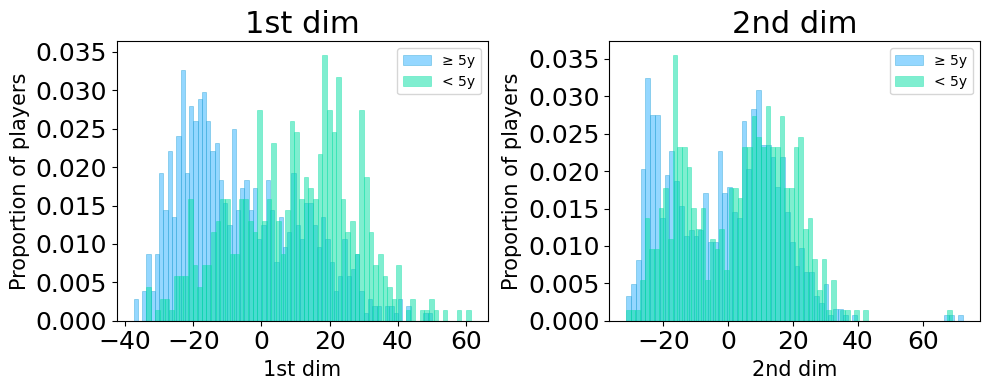

In [64]:
pca2 = PCA(n_components=2)
X_n  = pca2.fit_transform(X)
X_n  = pd.DataFrame(data= X_n, columns= ['1st dim', '2nd dim'])

fig, ax = plt.subplots(1,2, figsize=(10, 4))
plot_hists_var_outcome(X_n, y, '1st dim', '1st dim', ax[0], Normalize=True);
plot_hists_var_outcome(X_n, y, '2nd dim', '2nd dim', ax[1], Normalize=True);
fig.tight_layout()

Dans cette configuration, nous voyons que les distributions des variables conditionnelles dim1|y = 1 et dim1|y = 0 
sont assez disjointes, contrairement à celles de la deuxième dimension ( dim2|y = 1 et dim2|y = 0). Cette deuxième dimension ne doint pas expliquer beaucoup de variance.

In [65]:
clf1 = LogisticRegression()
clf1.fit(X_n[['1st dim']].loc[:1072], y.loc[:1072].values.reshape(-1,1))
y_hat1 = clf1.predict(X_n[['1st dim']].loc[1072:])
print('F1 score expliqué par la première composante: ' + str(np.round(f1_score(y.loc[1072:].values, y_hat1), decimals=4)))

F1 score expliqué par la première composante: 0.743


In [66]:
clf2 = LogisticRegression()
clf2.fit(X_n.loc[:1072], y.loc[:1072].values.reshape(-1,1))
y_hat2 = clf2.predict(X_n.loc[1072:])
print('F1 score expliqué par les deux premières composantes: ' + str(np.round(f1_score(y.loc[1072:].values, y_hat2), decimals=4)))

F1 score expliqué par les deux premières composantes: 0.7584


Projetter les données sur les deux premières composantes revient qualitativement et quantitativement à faire ce que l'on avait fait: à selectionner certaines variables peu corrélées et entrainer des classificateurs.
Avec cette dernière analyse on comprend mieux pourquoi les modèles plus complexes ne peuvent pas être plus performants,  simplement parce que la structure des données est bidimensionnelle, et que le sous espace qui importe pour la décision est lui unidimensionel. Si on ne fait pas attention de crossvalider correctement, utiliser des classifieurs plus complexes ne peut conduire qu'à "overfitter" les données.

Le fait le sous espace de décision soit unidimensionel explique, mais il faudrait expliciter d'avantage la raison,  pourquoi on voit une coïncidence entre le F1 score d'un modèle naïf et celle de modèles plus ou moins complexes. 
Sachant que la régréssion logistique est le bon modèle pour les données, on pense que cette coincidence numérique est due au fait que les deux distribitions dim1 |y= et dim1|y=0 se chevauchent bien, bien que leurs modes soient clairement distincts.

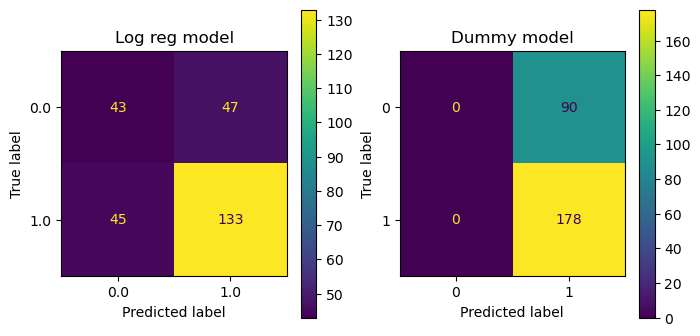

In [67]:
cm  = confusion_matrix(y.loc[1072:].values, y_hat1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf1.classes_);
cm  = confusion_matrix(y.loc[1072:].values, np.ones_like(y.loc[1072:].values))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(1,2, figsize=(8,4));
disp1.plot(ax=ax[0]);
ax[0].set_title('Log reg model');

disp.plot(ax=ax[1]);
ax[1].set_title('Dummy model');


# Intégration du modèle

In [ ]:
log_reg_model =  model_lr.best_estimator_

In [ ]:
joblib.dump(log_reg_model, 'log_reg.pkl')

In [ ]:
lr_2 = joblib.load('log_reg.pkl')
log_reg_columns = list(X_norm.columns)
joblib.dump(log_reg_columns, 'log_reg_columns.pkl')

Le code de l'API est dans le fichier log_reg_API.py.

Pour la lancer: 

a) installer l'environement conda:  conda create --name ds_test --file spec-file.txt

b) activer l'environement:  source activate ds_test

c) lancer dans l'environement: python log_reg_API.py

d) Faire une requête:

In [ ]:
sample = [
    {'GP': 47,
     'FG%': 35.2,
     '3P Made':0.7,
     'FT%':60.4,
     'REB': 4.1,
     'AST': 2.1,
     }
];

In [ ]:
from flask import request, json

BASE = "http://127.0.0.1:12345/predict"

headers = {"Content-Type": "application/json; charset=utf-8"}
data = sample
# 
response = request.post(BASE, headers=headers, json=data)

print("Status Code: ", response.status_code)
print("JSON Response: ", response.json())